In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Hyperparameter optimization for kernel-based machine learning

In this section, we discuss how to set up a hyperparameter search for quantum-classical models. As with other machine learning algorithms, you need to set, read from default settings, or optimize different parameters. With quantum kernels, you should specify a feature map, Pauli transformations, and the Pauli rotation factor. Unlike classical models, a change of parameters in quantum leads to different models with new decision boundaries. A standard classical machine learning approach involves defining a grid of parameters and performing a grid search, and trying all possible combinations on the grid.

`Scikit-learn` provides two options for fine-tuning the hyperparameter: `GridSearchCV` and `RandomizedSearchCV`. In the code examples, we focus on `GridSearchCV`. The transition to `RandomizedSearchCV` is an easy change.

The SVC estimator is used with `GridSearchCV`. SVC can accept custom kernels as callables. However, how do we combine quantum parameters that determine the kernel with SVC estimator parameters like regularization? The key is to create a grid of kernels and a way to look up specific parameters that were used to create a kernel.

In [2]:
# Standard packages
import numpy as np, pandas as pd
import itertools
import matplotlib.pyplot as plt

# scikit-learn
from sklearn.svm import SVC
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

#Qiskit
import qiskit
from qiskit.circuit.library import PauliFeatureMap

## Data

Create convenience functions for on-demand data generation for XOR, Moons, and Circles data sets.

In [3]:
def createXORdata(n_samples):
    rng = np.random.RandomState() # pylint: disable=no-member
    X = rng.randn(n_samples, 2)
    return X, (np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)).astype(int)
def createMoonsData(n_samples,noise):
    X = make_moons(n_samples=n_samples,noise = noise)
    return X[0],X[1]
def createCirclesData(n_samples,noise,factor):
    X = make_circles(n_samples=n_samples,noise = noise,factor=factor)
    return X[0],X[1]

def generateData(kind:str,N:int,scale_minus_1_plus_1:bool=False):
    """
    Expects XOR, moons, circles
    """
    if kind=='XOR':
        X_train, Y_train = createXORdata(N)
        X_validation, Y_validation = createXORdata(N)
        X_test, Y_test = createXORdata(N)
    elif kind=='moons':
        X_train, Y_train = createMoonsData(N,0.2)
        X_validation, Y_validation = createMoonsData(N,0.2)
        X_test, Y_test = createMoonsData(N,0.2)
    elif kind == 'circles':
        X_train, Y_train = createCirclesData(n_samples=N,noise = 0.1,factor=0.5)
        X_validation, Y_validation = createCirclesData(n_samples=N,noise = 0.1,factor=0.5)
        X_test, Y_test = createCirclesData(n_samples=N,noise = 0.1,factor=0.5)
    else:
        raise NotImplementedError
    
    # apply scaler to [-1,1]
    if scale_minus_1_plus_1:
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_validation = scaler.transform(X_validation)
        X_test = scaler.transform(X_test)
        
    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test

Visualizations of generated data:

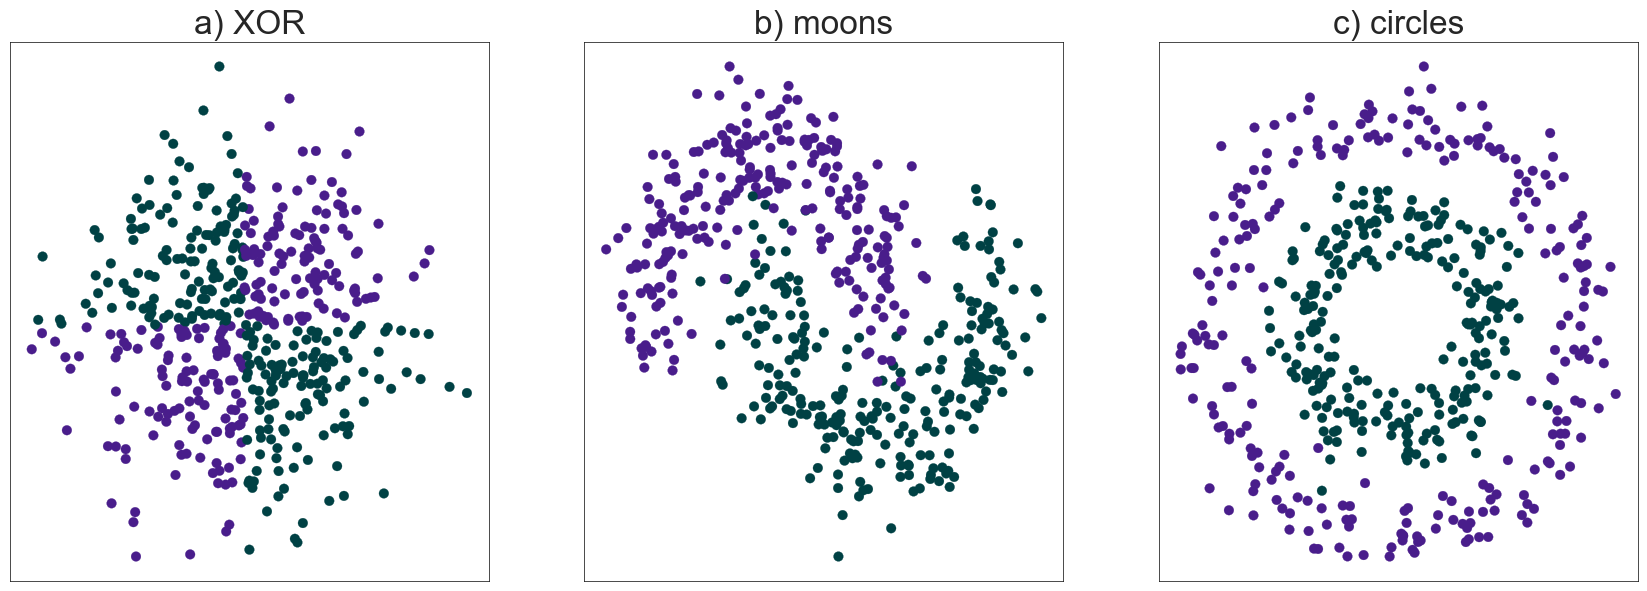

In [4]:
fig, ax = plt.subplots(1, 3,figsize=(21,7))
d = dict()
d[0]="a"
d[1]="b"
d[2]="c"
i=0
for kind in ["XOR",'moons','circles']:
    X_train, X_validation, X_test, y_train, y_validation, y_test = generateData(kind,500,scale_minus_1_plus_1=True)
    ax[i].scatter(x=X_train[:,0], y=X_train[:,1],c = y_train)
    ax[i].set_title(d[i]+") "+kind,size=24)
    ax[i].yaxis.set_major_locator(plt.NullLocator()) #https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
    ax[i].xaxis.set_major_locator(plt.NullLocator())
    i+=1

# Hyperparameter search

For grid search to work, we define at least one training and one validation subset. By default, the module performs v-fold cross-validation. For the sake of comparison with other models, it is usually preferable to have fixed training and validation data. We use the predefined split as shown below.

In [5]:
X_train, X_validation, X_test, y_train, y_validation, y_test = \
    generateData("circles",50,scale_minus_1_plus_1=True)
X_train_validation = np.concatenate((X_train, X_validation),axis=0)
y_train_validation = np.concatenate((y_train, y_validation),axis=0)

predefined_split = np.concatenate(([-1]*y_train.shape[0], \
                                   [0]*y_validation.shape[0]))
ps = PredefinedSplit(predefined_split)

Next, we define the parameter grid for the kernel, transform it into a list of kernels, and store the kernel-parameter reference as a dictionary object. This is needed for looking up parameters that correspond to the selected kernel.

The quantum kernel grid is defined by Pauli transformations, Pauli rotation factor $\alpha$, introduced in quantum feature maps section, repetitions and entanglement.

Please note the grid below is provided for demonstration purposes only and is designed to minimize computation time. It isn’t meant to be exhaustive. For a more detailed search, consider adding other permitted Pauli transformations, such as $Z$ and $ZZ$, and use a finer grid for $\alpha$. For multi-qubit feature maps, you can also experiment with different entanglement schemes. Currently, the default “full” entanglement structure is used.

In [6]:
from functools import lru_cache
from qiskit_machine_learning.kernels import fidelity_statevector_kernel

class FidelityStatevectorKernel(fidelity_statevector_kernel.FidelityStatevectorKernel):
    """Extends `qiskit_machine_learning.kernels.fidelity_statevector_kernel.FidelityStatevectorKernel`
    so that it can be pickled.  This is necessary to save and load object and use many parallel
    processing frameworks like ray and sklearn which require pickling objects to work.
    Maintaining this until the qiskit `FidelityStatevectorKernel` is fixed, at which point this
    will be set equal to the qiskit class and deprecated.  Fix progress can be tracked in the
    following github issue: https://github.com/Qiskit/qiskit-machine-learning/issues/607
    """

    def __getstate__(self):
        result = self.__dict__.copy()
        result["_get_statevector"] = None
        result["_lru_cache_maxsize"] = self._get_statevector.cache_parameters()[
            "maxsize"
        ]
        return result

    def __setstate__(self, state):
        max_size = state["_lru_cache_maxsize"]
        del state["_lru_cache_maxsize"]
        self.__dict__ = state
        self._get_statevector = lru_cache(maxsize=max_size)(self._get_statevector_)

In [7]:
kernels = [] # list for kernel callables
kernels_dict = dict() # dictionary for lookup of kernel parameters

# Kernels grid
grid_params_kernel = dict()
grid_params_kernel["alpha"] = [(i1/5.) for i1 in range(1,10,1)]
grid_params_kernel["paulis"] = [["X"],["Y"],["Z"],["XX"],["XY"],\
                                ["XZ"],["YY"],["YZ"],["ZZ"]]
grid_params_kernel["reps"] = [1,2]
grid_params_kernel["entanglement"] = ["full"]

feature_dim = X_train.shape[1]

# Extracting all combinations of kernel parameters
grid_params_kernel_values = \
    list(itertools.product(*grid_params_kernel.values()))

# Converting parameters grid into list of kernel callables
for alpha,pauli,reps,entanglement in grid_params_kernel_values:

    feature_map = PauliFeatureMap(feature_dimension=feature_dim, \
                                  alpha=alpha, \
                                  reps=reps, \
                                  paulis=pauli, \
                                  entanglement=entanglement \
                                 )
    kernel = FidelityStatevectorKernel(feature_map=feature_map)
    obj_str = str(kernel)
    obj_str = obj_str[obj_str.find("0x"):-1]

    kernels_dict[obj_str] = {"alpha":alpha, \
                             "paulis":pauli, \
                             "reps":reps, \
                             "entanglement":entanglement
                            }

    kernels.append(kernel.evaluate)

Next, we combine the grid of kernels with classical model parameters and start the estimation. In order to minimize computation time, we have included only one value for the regularization parameter. For a finer-grade search, we recommend including a more detailed grid for parameter $C$, such as $[0.1,1,10,100,1000]$.

<b>Note:</b> Currently, we use the statevector simulator, so for smaller problems it makes sense to run multiple jobs in parallel. When the physical backend is used, it may make sense to run tasks sequentially and utilize Qiskit Runtime.

In [8]:
params_qsvc = {'C':[1]}
params_qsvc['kernel'] = kernels

svc = SVC() # estimator to be used in GridSearchCV

# Define grid search estimator with parameters grid, predefined split and parallel processing
estimator = GridSearchCV(svc, params_qsvc, n_jobs=4, verbose=1, \
                         cv=ps)
estimator.fit(X = X_train_validation,y = y_train_validation)

# The next line is very verbose. 
# Please, uncomment to see detailed results.
#print("All results -----------\n", estimator.cv_results_)
print("Best ------------------\n", estimator.best_params_)
q_kernel_obj_str = str(estimator.best_params_.get('kernel'))
# Retrieving kernel parameters for the best kernel
q_kernel_obj_str = q_kernel_obj_str[q_kernel_obj_str.find("0x"):-2]
print("Best kernel -----------\n",kernels_dict[q_kernel_obj_str])

Fitting 1 folds for each of 162 candidates, totalling 162 fits
Best ------------------
 {'C': 1, 'kernel': <bound method FidelityStatevectorKernel.evaluate of <__main__.FidelityStatevectorKernel object at 0x7fe79ebaf100>>}
Best kernel -----------
 {'alpha': 1.0, 'paulis': ['Z'], 'reps': 2, 'entanglement': 'full'}


The printout above shows the best selected model. As you can see, the quantum kernel is shown as the object ID. We decode it on the next line using the kernels dictionary.

In [9]:
# Retrieve kernel parameters for grid search iterations
test_scores = estimator.cv_results_['split0_test_score']
params = estimator.cv_results_['params']

for i_param in params:
    q_kernel_obj_str = str(i_param['kernel'])
    q_kernel_obj_str = \
        q_kernel_obj_str[q_kernel_obj_str.find("0x"):-2]
    i_param["kernel"] = kernels_dict[q_kernel_obj_str]

for i,i_param in enumerate(params):
    i_param['test_score'] = test_scores[i]

In [10]:
with pd.option_context('display.max_rows', None, \
                       'display.max_columns', None, \
                       'max_colwidth', 1, \
                       'display.width', 1000 \
                      ):
    print(pd.DataFrame(params).sort_values(by=['test_score'], \
                                          ascending=False).head(10))

     C                                                              kernel  test_score
95   1  {'alpha': 1.2, 'paulis': ['Z'], 'reps': 2, 'entanglement': 'full'}  1.0       
112  1  {'alpha': 1.4, 'paulis': ['Z'], 'reps': 1, 'entanglement': 'full'}  1.0       
127  1  {'alpha': 1.6, 'paulis': ['X'], 'reps': 2, 'entanglement': 'full'}  1.0       
77   1  {'alpha': 1.0, 'paulis': ['Z'], 'reps': 2, 'entanglement': 'full'}  1.0       
113  1  {'alpha': 1.4, 'paulis': ['Z'], 'reps': 2, 'entanglement': 'full'}  1.0       
92   1  {'alpha': 1.2, 'paulis': ['Y'], 'reps': 1, 'entanglement': 'full'}  1.0       
131  1  {'alpha': 1.6, 'paulis': ['Z'], 'reps': 2, 'entanglement': 'full'}  1.0       
109  1  {'alpha': 1.4, 'paulis': ['X'], 'reps': 2, 'entanglement': 'full'}  1.0       
110  1  {'alpha': 1.4, 'paulis': ['Y'], 'reps': 1, 'entanglement': 'full'}  1.0       
91   1  {'alpha': 1.2, 'paulis': ['X'], 'reps': 2, 'entanglement': 'full'}  1.0       


To summarize, the grid search was performed on both classical and quantum kernel parameters. The full history of results can be printed out. In general, this procedure is used to choose the best model as well as to assist in finding the most suitable quantum kernel and feature map topology.

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>